In [8]:
import json
import random
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import heapq

In [9]:
NYC_AIRPORTS = ['JFK', 'EWR', 'LGA']
JAPAN_AIRPORTS = ['NRT', 'HND']
KOREA_AIRPORTS = ['ICN', 'GMP'] 
HK_AIRPORTS = ['HKG'] 
TAIWAN_AIRPORTS = ['TPE', 'TSA'] 
SHANGHAI_AIRPORTS = ['PVG', 'SHA']

# allowable intermediate airport for multiple-day stays
ALLOWED_INTERMEDIATE_STAY_AIRPORTS = JAPAN_AIRPORTS + KOREA_AIRPORTS + HK_AIRPORTS + TAIWAN_AIRPORTS

# time limits for layover
MIN_TRANSIT_LAYOVER_HOURS = 3.0  # Minimum time
MAX_TRANSIT_LAYOVER_HOURS = 24.0 # Maximum time

# time limits for long time stays
MIN_INTERMEDIATE_STAY_HOURS = 3 * 24.0 
MAX_INTERMEDIATE_STAY_HOURS = 10 * 24.0

In [10]:
file_path='processed_flights_data.json'

with open(file_path, 'r', encoding='utf-8') as f:
        flights_data_raw = json.load(f) 

def parse_datetime(dt_str):
    if not dt_str: return None
    try: return datetime.fromisoformat(dt_str)
    except ValueError: return None

# process flight data
flights = []
for flight_dict in flights_data_raw:
    dep_dt = parse_datetime(flight_dict.get('departure_datetime_obj'))
    arr_dt = parse_datetime(flight_dict.get('arrival_datetime_obj'))
    price = flight_dict.get('price_usd')
    if dep_dt and arr_dt and price is not None and flight_dict.get('departure_airport_code') and flight_dict.get('arrival_airport_code'):
        flights.append({
            'from': flight_dict['departure_airport_code'],
            'to': flight_dict['arrival_airport_code'],
            'departure': dep_dt,
            'arrival': arr_dt,
            'price': float(price),
            'airline': flight_dict.get('airline', 'N/A'),
            'original_data': flight_dict 
        })

In [11]:
def modified_dijkstra():
    
    if not flights:
        print('No valid flight data')
        return None

    flights.sort(key=lambda f: f['departure'])

    pq = []
    min_costs = {}

    for flight in flights:
        if flight['from'] in NYC_AIRPORTS:
            initial_price = flight['price']
            initial_nyc_departure_time = flight['departure'] # record the departure time to calculate the total travel time

            # flag：0 - has not yet reached an Asian city that allows long time stays；1 - has reached an Asian city
            initial_major_segment_completed_flag = 0 
            if flight['to'] in ALLOWED_INTERMEDIATE_STAY_AIRPORTS:
                initial_major_segment_completed_flag = 1 
            
            state_key = (flight['to'], flight['arrival'], initial_major_segment_completed_flag)

            cost_tuple = (initial_price, (flight['arrival'] - flight['departure']).total_seconds())

            if cost_tuple < min_costs.get(state_key, (float('inf'), float('inf'))):
                min_costs[state_key] = cost_tuple
                heapq.heappush(pq, (
                    cost_tuple,
                    flight['to'],
                    flight['arrival'],
                    initial_major_segment_completed_flag,
                    [flight], 
                    initial_nyc_departure_time
                ))
    
    optimal_solution = None

    while pq:
        (cost, current_airport, current_arrival_time, current_major_segment_completed_flag, 
         current_path, initial_nyc_departure_time) = heapq.heappop(pq)
        current_total_price, current_total_travel_time_sec = cost

        # if a better path to reach this state has been found, then skip it
        state_key_for_check = (current_airport, current_arrival_time, current_major_segment_completed_flag)
        if (current_total_price, current_total_travel_time_sec) > min_costs.get(state_key_for_check, (float('inf'), float('inf'))):
            continue

        # check if arrived in Shanghai and have passed through the permitted citys
        if current_airport in SHANGHAI_AIRPORTS and current_major_segment_completed_flag == 1:
            optimal_solution = {
                'path': current_path,
                'total_price': current_total_price,
                'total_travel_time_seconds': current_total_travel_time_sec
            }
            break 

        # extend to the next flight
        for next_flight in flights:
            if next_flight['from'] == current_airport:
                layover_duration = next_flight['departure'] - current_arrival_time

                if current_major_segment_completed_flag == 0:
                    # segment 0: still searching for allowed intermediate or making short layovers
                    # apply the layover rule
                    if not (timedelta(hours=MIN_TRANSIT_LAYOVER_HOURS) <= layover_duration <= timedelta(hours=MAX_TRANSIT_LAYOVER_HOURS)):
                        continue
                    
                    # update flag：if the flight reach the permitted city
                    new_major_segment_completed_flag = 0
                    if next_flight['to'] in ALLOWED_INTERMEDIATE_STAY_AIRPORTS:
                        new_major_segment_completed_flag = 1
                
                elif current_major_segment_completed_flag == 1:
                    # segment 1：having arrived in an Asian city, looking for flight to Shanghai
                    
                    if current_airport not in ALLOWED_INTERMEDIATE_STAY_AIRPORTS:
                        continue 
                    
                    # apply the multi-day stay rule to the current transit
                    if not (timedelta(hours=MIN_INTERMEDIATE_STAY_HOURS) <= layover_duration <= timedelta(hours=MAX_INTERMEDIATE_STAY_HOURS)):
                        continue
                    
                    # it is mandatory that after leaving an Asian city where stay is permitted, the next stop must be Shanghai
                    if next_flight['to'] not in SHANGHAI_AIRPORTS:
                        continue

                    new_major_segment_completed_flag = 1 
                    
                new_total_price = current_total_price + next_flight['price']
                
                # calculate the new total travel time
                new_total_travel_time_sec = (next_flight['arrival'] - initial_nyc_departure_time).total_seconds()

                next_arrival_airport = next_flight['to']
                next_arrival_time = next_flight['arrival']
                
                # if the new path is superior, then update it and add it to the priority queue
                new_cost_tuple = (new_total_price, new_total_travel_time_sec)
                next_state_key = (next_arrival_airport, next_arrival_time, new_major_segment_completed_flag)

                if new_cost_tuple < min_costs.get(next_state_key, (float('inf'), float('inf'))):
                    min_costs[next_state_key] = new_cost_tuple
                    new_path = current_path + [next_flight]
                    heapq.heappush(pq, (
                        new_cost_tuple,
                        next_arrival_airport,
                        next_arrival_time,
                        new_major_segment_completed_flag,
                        new_path,
                        initial_nyc_departure_time
                    ))
    
    # if an optimal solution is found, print the details
    if optimal_solution:
        print('\nOptimal flight (TEG + Dijkstra)')
        print(f'Total price: ${optimal_solution['total_price']:.2f} USD')
        total_hours = optimal_solution['total_travel_time_seconds'] / 3600
        print(f'Total time: {total_hours:.2f} hour ({timedelta(seconds=optimal_solution['total_travel_time_seconds'])})')
        
        print('\nDetail journey:')
        for i, flight_leg in enumerate(optimal_solution['path']):
            print(f'   The {i+1} step:')
            print(f'     Airline: {flight_leg['airline'].strip()}')
            print(f'     Flight: {flight_leg['from']} -> {flight_leg['to']}')
            print(f'     Depart: {flight_leg['departure'].isoformat()}')
            print(f'     Arrival: {flight_leg['arrival'].isoformat()}')
            print(f'     Price: ${flight_leg['price']:.2f}')
            if i < len(optimal_solution['path']) - 1:
                next_flight_leg = optimal_solution['path'][i+1]
                layover = next_flight_leg['departure'] - flight_leg['arrival']
                print(f'     --- Layover time: {layover} ---')
        return optimal_solution
    else:
        print('unable to find suitable flight')

        return None

In [12]:
optimal_flight = modified_dijkstra()


Optimal flight (TEG + Dijkstra)
Total price: $803.11 USD
Total time: 115.42 hour (4 days, 19:25:00)

Detail journey:
   The 1 step:
     Airline: United;
     Flight: EWR -> LAX
     Depart: 2025-07-22T06:00:00
     Arrival: 2025-07-22T08:56:00
     Price: $127.82
     --- Layover time: 4:39:00 ---
   The 2 step:
     Airline: JAL; American, Alaska;
     Flight: LAX -> NRT
     Depart: 2025-07-22T13:35:00
     Arrival: 2025-07-23T16:35:00
     Price: $411.95
     --- Layover time: 3 days, 6:10:00 ---
   The 3 step:
     Airline: Spring Japan;
     Flight: NRT -> PVG
     Depart: 2025-07-26T22:45:00
     Arrival: 2025-07-27T01:25:00
     Price: $263.34


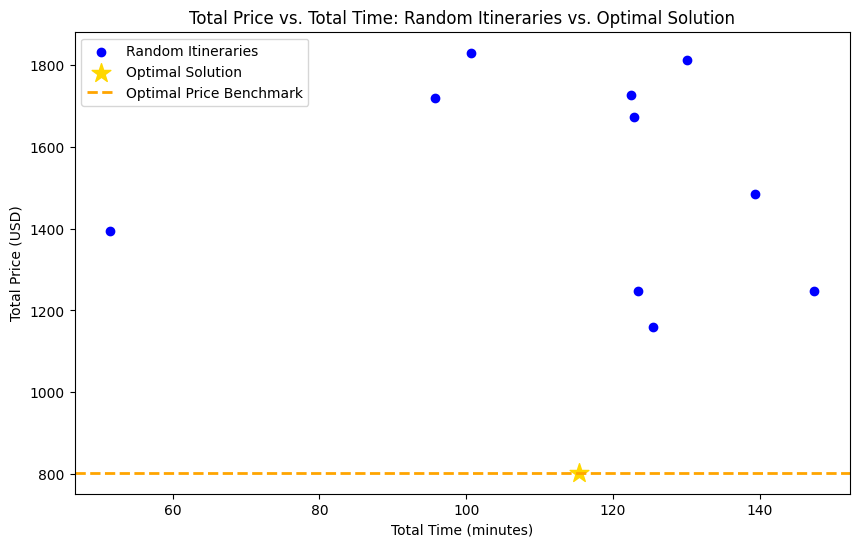

In [ ]:
def is_valid_connection(prev, current):
    min_layover = timedelta(minutes=180)  # min
    return current['departure'] > prev['arrival'] + min_layover

def generate_random_itinerary(start, destination, max_hops):
    path = []
    current_airport = start
    visited = set()

    for _ in range(max_hops):
        options = [f for f in flights if f['from'] == current_airport and f['to'] not in visited]
        if not options:
            break
        next_flight = random.choice(options)

        if path and not is_valid_connection(path[-1], next_flight):
            continue  # skip if layover invalid

        path.append(next_flight)
        current_airport = next_flight['to']
        visited.add(current_airport)

        if current_airport == destination:
            return path
    return None 

random_itineraries = []
for _ in range(100):
    itinerary = generate_random_itinerary('EWR', 'PVG', max_hops=10)
    if itinerary:
        random_itineraries.append(itinerary)

# calculate total prices and total times for random itineraries
random_prices = [sum(f['price'] for f in itinerary) for itinerary in random_itineraries]
random_times = [
    (itinerary[-1]['arrival'] - itinerary[0]['departure']).total_seconds() / 3600  # minutes
    for itinerary in random_itineraries
]

plt.figure(figsize=(10, 6))
plt.scatter(random_times, random_prices, color='blue', label='Random Itineraries')

# plot optimal solution as a star
if optimal_flight:
    opt_time = (optimal_flight['path'][-1]['arrival'] - optimal_flight['path'][0]['departure']).total_seconds() / 3600
    opt_price = optimal_flight['total_price']
    plt.scatter([opt_time], [opt_price], color='gold', marker='*', s=200, label='Optimal Solution')
    plt.axhline(opt_price, color='orange', linestyle='--', linewidth=2, label='Optimal Price Benchmark')

plt.xlabel('Total Time (minutes)')
plt.ylabel('Total Price (USD)')
plt.title('Total Price vs. Total Time: Random Itineraries vs. Optimal Solution')
plt.legend()
# plt.savefig('randomvsoptimal.png')
plt.show()


In [14]:
print('\n--- Random Itineraries ---')
for i, itinerary in enumerate(random_itineraries):
    print(f'\nItinerary {i+1}:')
    for flight in itinerary:
        print(f'  {flight['from']} -> {flight['to']} | '
              f'Departure: {flight['departure'].isoformat()} | '
              f'Arrival: {flight['arrival'].isoformat()} | '
              f'Price: ${flight['price']:.2f} | Airline: {flight['airline']}')
    total_price = sum(f['price'] for f in itinerary)
    print(f'Total Price: ${total_price:.2f}')


--- Random Itineraries ---

Itinerary 1:
  EWR -> ORD | Departure: 2025-07-21T16:58:00 | Arrival: 2025-07-21T18:40:00 | Price: $163.24 | Airline: United;
  ORD -> HND | Departure: 2025-07-24T17:45:00 | Arrival: 2025-07-25T21:15:00 | Price: $1073.38 | Airline: ANA; United;
  HND -> PVG | Departure: 2025-07-26T17:10:00 | Arrival: 2025-07-26T19:25:00 | Price: $490.49 | Airline: Shanghai Airlines; China Eastern;
Total Price: $1727.11

Itinerary 2:
  EWR -> SEA | Departure: 2025-07-21T16:00:00 | Arrival: 2025-07-21T19:12:00 | Price: $187.11 | Airline: Alaska; Hawaiian;
  SEA -> HND | Departure: 2025-07-24T11:50:00 | Arrival: 2025-07-25T14:15:00 | Price: $569.80 | Airline: Delta;
  HND -> PVG | Departure: 2025-07-26T17:10:00 | Arrival: 2025-07-26T19:25:00 | Price: $490.49 | Airline: Shanghai Airlines; China Eastern;
Total Price: $1247.40

Itinerary 3:
  EWR -> YYZ | Departure: 2025-07-21T19:55:00 | Arrival: 2025-07-21T21:44:00 | Price: $102.41 | Airline: Air Canada; United; Operated by Air 